In [1]:
using Flux, Statistics
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, @epochs
using Flux.Losses: logitcrossentropy
using Base: @kwdef
using MLDatasets
using Plots

In [2]:
include("network.jl")
include("vsa.jl")

similarity_outer (generic function with 1 method)

In [3]:
model = Chain(PhasorDense(1024 => 32), )

Chain(
  PhasorDense(1024 => 32),              # 32_800 parameters
) 

In [4]:
x = random_symbols((100, 1024))

100×1024 Matrix{Float64}:
  0.687092   -0.126386    0.125727   …  -0.693004    0.0166793   0.616606
 -0.76522     0.786713   -0.800262      -0.642941    0.0730805   0.472716
  0.0210686   0.90833    -0.937022       0.475139   -0.151935   -0.25034
 -0.801221   -0.318685    0.202085      -0.877943    0.0952944  -0.0225643
  0.387303    0.529438    0.48421       -0.939153   -0.621548   -0.548894
  0.857039   -0.989937   -0.913151   …   0.753837   -0.901292   -0.792999
  0.587331    0.220039   -0.218529       0.208451   -0.424536    0.101448
  0.734702   -0.711839    0.775741       0.0347855  -0.771009    0.682421
  0.791041   -0.0253949   0.494476      -0.207323    0.906782    0.880057
  0.399869   -0.459501    0.0170496     -0.351493    0.960089   -0.578408
  ⋮                                  ⋱                          
  0.279181   -0.860647    0.480624       0.625587    0.696531    0.194756
 -0.612085    0.510374   -0.33923       -0.731866    0.669986   -0.488914
  0.21289    -0.39383

In [5]:
x |> size

(100, 1024)

In [6]:
y = complex_to_angle(angle_to_complex(x) * model[1].weight' .+ model[1].bias')

100×32 Matrix{Float64}:
  0.176103    -0.0732664    0.384671     …  -0.0548781   0.39728
  0.364007    -0.123678     0.603877         0.179696    0.0287292
 -0.00747109   0.109333     0.625497        -0.101664   -0.137404
 -0.20119     -0.502683     0.769824         0.0777241   0.558568
 -0.195884     0.211923     0.0667377       -0.0184502  -0.117379
  0.296854    -0.397422    -0.87867      …   0.100754   -0.110373
  0.101897     0.387588     0.685001         0.435242    0.173728
  0.0266282   -0.147567    -0.396287         0.066251   -0.0524573
  0.0993028    0.364697     0.410418         0.0509599   0.0271718
 -0.0696366    0.00210634  -0.238991        -0.573919    0.349621
  ⋮                                      ⋱   ⋮          
  0.58429      0.217148     0.000893442     -0.0337574   0.000424771
 -0.33968     -0.0986215   -0.308563         0.805207    0.022795
  0.888149    -0.373386    -0.0325002       -0.191393   -0.136372
 -0.257115    -0.155475     0.447089        -0.413675   

In [7]:
y = model(x)

100×32 Matrix{Float64}:
  0.176103    -0.0732664    0.384671     …  -0.0548781   0.39728
  0.364007    -0.123678     0.603877         0.179696    0.0287292
 -0.00747109   0.109333     0.625497        -0.101664   -0.137404
 -0.20119     -0.502683     0.769824         0.0777241   0.558568
 -0.195884     0.211923     0.0667377       -0.0184502  -0.117379
  0.296854    -0.397422    -0.87867      …   0.100754   -0.110373
  0.101897     0.387588     0.685001         0.435242    0.173728
  0.0266282   -0.147567    -0.396287         0.066251   -0.0524573
  0.0993028    0.364697     0.410418         0.0509599   0.0271718
 -0.0696366    0.00210634  -0.238991        -0.573919    0.349621
  ⋮                                      ⋱   ⋮          
  0.58429      0.217148     0.000893442     -0.0337574   0.000424771
 -0.33968     -0.0986215   -0.308563         0.805207    0.022795
  0.888149    -0.373386    -0.0325002       -0.191393   -0.136372
 -0.257115    -0.155475     0.447089        -0.413675   

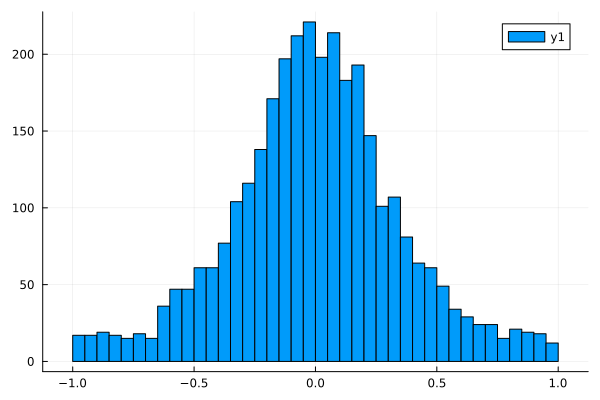

In [8]:
histogram(y |> vec)

In [9]:
function getdata(args)
    ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

    @info "Getting and transforming data"

    ## Load dataset
    xtrain, ytrain = MLDatasets.MNIST(:train)[:]
    xtest, ytest = MLDatasets.MNIST(:test)[:]

    ## Reshape input data to flatten each image into a linear array
    xtrain = Flux.flatten(xtrain)
    xtest = Flux.flatten(xtest)

    ## One-hot-encode the labels
    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    ## Create two DataLoader objects (mini-batch iterators)
    train_loader = DataLoader((xtrain, ytrain), batchsize=args.batchsize, shuffle=true)
    test_loader = DataLoader((xtest, ytest), batchsize=args.batchsize)

    return train_loader, test_loader
end

getdata (generic function with 1 method)

In [10]:
function build_model(; imgsize=(28,28,1), nclasses=10)
    return Chain( PhasorDense(prod(imgsize) => 32),
                  PhasorDense(32 => nclasses))
end

build_model (generic function with 1 method)

In [11]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [12]:
train_loader, test_loader = getdata(Args())

┌ Info: Getting and transforming data
└ @ Main /Users/wilkie/code/phasor_julia/net_test.ipynb:4


(DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=256), DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=256))

In [13]:
x, y = first(train_loader)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

In [14]:
x

784×256 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱       ⋮                        ⋮
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [15]:
y

10×256 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅

In [16]:
phasor_model = build_model()

Chain(
  PhasorDense(784 => 32),               # 25_120 parameters
  PhasorDense(32 => 10),                # 330 parameters
)                   # Total: 4 arrays, 25_450 parameters, 199.078 KiB.

In [17]:
pc = phasor_model(x')

256×10 Matrix{Float32}:
  0.850572  -0.088192    0.79389    …  -0.199711   -0.937679   -0.858137
 -0.756533   0.0498885  -0.0392542     -0.257534   -0.105078   -0.99674
  0.941735   0.409357    0.754463       0.377124   -0.602684   -0.826188
  0.856593   0.0246105   0.873347      -0.143886   -0.969777   -0.904788
 -0.985562   0.0955502  -0.16083        0.336286   -0.495901    0.895962
  0.899336   0.081894   -0.0554577  …  -0.0250401  -0.0540258  -0.947937
  0.474772  -0.428823    0.601548      -0.159658    0.830716    0.937226
 -0.959566  -0.0188329  -0.075397       0.243071   -0.280546    0.978875
  0.989102   0.0893717   0.554108       0.383385   -0.890768    0.973302
 -0.935893  -0.0183847  -0.0266397      0.138864   -0.425884   -0.448588
  ⋮                                 ⋱                          
  0.808632  -0.0726933   0.408632       0.190551   -0.553528    0.9159
 -0.926082  -0.278537    0.712915       0.522761    0.998403   -0.812461
  0.974768   0.0571275   0.134945      

In [18]:
function quadrature_loss(phases::AbstractMatrix, truth::AbstractMatrix)
    targets = 0.5 .* truth
    sim = similarity(phases, targets)
    return 1.0 .- sim
end


quadrature_loss (generic function with 1 method)

In [19]:
function accuracy_quadrature(phases::AbstractMatrix, truth::AbstractMatrix)
    predictions = getindex.(argmin(phases, dims=2), 2)
    labels = getindex.(findall(truth), 1)
    return predictions .== labels
end

accuracy_quadrature (generic function with 1 method)

In [20]:
mean(accuracy_quadrature(pc, y))

0.11328125

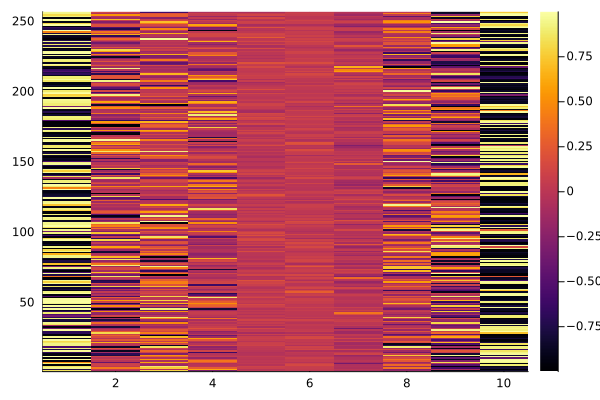

In [21]:
heatmap(pc)

In [22]:
function loss_and_accuracy(data_loader, model)
    acc = 0
    ls = 0.0f0
    num = 0
    for (x, y) in data_loader
        ŷ = model(x')
        
        ls += sum(quadrature_loss(ŷ, y'))
        acc += sum(accuracy_quadrature(ŷ, y)) ## Decode the output of the model
        num +=  size(x)[end]
    end
    return ls / num, acc / num
end

loss_and_accuracy (generic function with 1 method)

In [23]:
loss_and_accuracy(test_loader, phasor_model)

(0.6926817312517211, 0.0899)

In [24]:
using Zygote: withgradient

In [25]:
function train(model; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    # if CUDA.functional() && args.use_cuda
    #     @info "Training on CUDA GPU"
    #     CUDA.allowscalar(false)
    #     device = gpu
    # else
        @info "Training on CPU"
        device = cpu
    # end

    ## Create test and train dataloaders
    train_loader, test_loader = getdata(args)

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt = Flux.setup(Adam(args.η), model)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        for (x, y) in train_loader
            x, y = transpose(device(x)), transpose(device(y)) ## transfer data to device
            loss, gs = withgradient(m -> mean(quadrature_loss(m(x), y)), model) ## compute gradient of the loss
            append!(losses, loss)
            Flux.Optimise.update!(opt, model, gs[1]) ## update parameters
        end

        ## Report on train and test
        train_loss, train_acc = loss_and_accuracy(train_loader, model)
        test_loss, test_acc = loss_and_accuracy(test_loader, model)
        println("Epoch=$epoch")
        println("  train_loss = $train_loss, train_accuracy = $train_acc")
        println("  test_loss = $test_loss, test_accuracy = $test_acc")
    end

    return losses
end

train (generic function with 1 method)

In [26]:
opt = Flux.setup(Adam(3e-4), phasor_model)

(layers = ((weight = Leaf(Adam{Float64}(0.0003, (0.9, 0.999), 1.0e-8), (ComplexF32[0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; … ; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im], ComplexF32[0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; … ; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.0003, (0.9, 0.999), 1.0e-8), (ComplexF32[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im], ComplexF32[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im], (0.9, 0.

In [27]:
gs = gradient(m -> mean(quadrature_loss(m(xt), yt)), phasor_model)

UndefVarError: UndefVarError: xt not defined

In [28]:
gs[1]

UndefVarError: UndefVarError: gs not defined

In [29]:
Flux.Optimise.update!(opt, phasor_model, gs[1])

UndefVarError: UndefVarError: gs not defined

In [31]:
loss_and_accuracy(train_loader, phasor_model)

(0.6914549317963006, 0.0887)

In [32]:
l2, l3 = getdata(Args())

┌ Info: Getting and transforming data
└ @ Main /Users/wilkie/code/phasor_julia/net_test.ipynb:4


(DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=256), DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=256))

In [33]:
loss_and_accuracy(l2, phasor_model)

(0.6914549317963002, 0.0887)

In [34]:
loss_and_accuracy(l3, phasor_model)

(0.6926817312517211, 0.0899)

In [35]:
l =train(phasor_model)

┌ Info: Training on CPU
└ @ Main /Users/wilkie/code/phasor_julia/net_test.ipynb:9
┌ Info: Getting and transforming data
└ @ Main /Users/wilkie/code/phasor_julia/net_test.ipynb:4


┌ Info: Constructing model and starting training
└ @ Main /Users/wilkie/code/phasor_julia/net_test.ipynb:16


Epoch=1
  train_loss = 0.06023967903066517, train_accuracy = 0.0017666666666666666
  test_loss = 0.05972832147418019, test_accuracy = 0.0012


Epoch=2
  train_loss = 0.037918801785480134, train_accuracy = 0.0021333333333333334
  test_loss = 0.03734057473199118, test_accuracy = 0.0011


Epoch=3
  train_loss = 0.029081343898066814, train_accuracy = 0.0022166666666666667
  test_loss = 0.028398884737462368, test_accuracy = 0.0016


Epoch=4
  train_loss = 0.024968155589232946, train_accuracy = 0.0017166666666666667
  test_loss = 0.024422428996794157, test_accuracy = 0.0013


Epoch=5
  train_loss = 0.022357217671258513, train_accuracy = 0.00185
  test_loss = 0.02196901775859751, test_accuracy = 0.0015


Epoch=6
  train_loss = 0.0205187494413267, train_accuracy = 0.00185
  test_loss = 0.020156398987061553, test_accuracy = 0.0016


Epoch=7
  train_loss = 0.01891623485071748, train_accuracy = 0.0014666666666666667
  test_loss = 0.018626150464633, test_accuracy = 0.001


Epoch=8
  train_loss = 0.018080729037438632, train_accuracy = 0.00135
  test_loss = 0.017856681873375895, test_accuracy = 0.0013


Epoch=9
  train_loss = 0.018029279381596285, train_accuracy = 0.0012833333333333334
  test_loss = 0.01780444834841833, test_accuracy = 0.0013


Epoch=10
  train_loss = 0.01619882576769922, train_accuracy = 0.0013
  test_loss = 0.016165774741772377, test_accuracy = 0.0015


2350-element Vector{Any}:
 0.7085278441546649
 0.5986425966416014
 0.5529654493653257
 0.4909804410562455
 0.42897285551680986
 0.3869205220626662
 0.3527859071579033
 0.33182702502158007
 0.31510008728685174
 0.28831200859758593
 ⋮
 0.015461808024070201
 0.016699417560323067
 0.01667067173002857
 0.015391377633041926
 0.015182154391683357
 0.013393894951657931
 0.015504197997627766
 0.016353171109225434
 0.019062187444202437

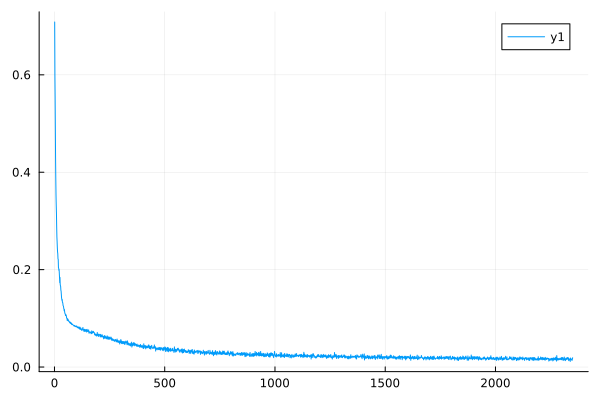

In [36]:
plot(l)